In [15]:
import pandas as pd
import numpy as np
import re
from google.colab import drive
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Normalizer
import scipy
import re
import pickle
import emoji
from multiprocessing import Pool
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
df_emoji = pd.read_csv("./drive/MyDrive/Comp 642 data/cleaned_dataset_eng_sentiment.csv")
df_no_emoji = pd.read_csv("./drive/MyDrive/Comp 642 data/cleaned_dataset_eng_sentiment_no_emoji_emoticon.csv")

# Preprocessing

In [18]:
# convert to lower case
df_emoji['processed_text'] = df_emoji['text'].str.lower()
df_no_emoji['processed_text'] = df_no_emoji['text'].str.lower()

In [19]:
# remove numbers
df_emoji['processed_text'] = df_emoji['processed_text'].str.replace('\d+', '')
df_no_emoji['processed_text'] = df_no_emoji['processed_text'].str.replace('\d+', '')

<ipython-input-19-dcf82b47b2b9>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_emoji['processed_text'] = df_emoji['processed_text'].str.replace('\d+', '')
<ipython-input-19-dcf82b47b2b9>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_no_emoji['processed_text'] = df_no_emoji['processed_text'].str.replace('\d+', '')


In [20]:
# remove punctuation
df_emoji['processed_text'] = df_emoji['processed_text'].str.translate(str.maketrans("", "", string.punctuation))
df_no_emoji['processed_text'] = df_no_emoji['processed_text'].str.translate(str.maketrans("", "", string.punctuation))

In [21]:
# remove empty string or NA
df_emoji = df_emoji[df_emoji['processed_text'] != '']
df_no_emoji = df_no_emoji[df_no_emoji['processed_text'] != '']
df_emoji = df_emoji.dropna()
df_no_emoji = df_no_emoji.dropna()

In [24]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [25]:
df_emoji['processed_text'] = df_emoji['processed_text'].apply(remove_stopwords)
df_no_emoji['processed_text'] = df_no_emoji['processed_text'].apply(remove_stopwords)

In [26]:
lemmatizer = WordNetLemmatizer()
def lemmatize_sentence(sentence):
    words = sentence.split()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # pos='v' for verbs
    return ' '.join(lemmatized_words)

In [29]:
df_emoji['processed_text'] =  df_emoji['processed_text'].apply(lemmatize_sentence)
df_no_emoji['processed_text'] =  df_no_emoji['processed_text'].apply(lemmatize_sentence)

In [30]:
df_emoji.to_csv("./drive/MyDrive/Comp 642 data/tweets_emoji.csv",  mode='w', index=False)

In [ ]:
with open('./drive/MyDrive/Comp 642 data/Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        word = Emoji_Dict[emot].replace(",", "").replace(":", "")
        text = re.sub(r'('+emot+')', word, text)
    return text.replace('_', ' ')

In [ ]:
df_emoji_text = df_emoji.copy()

In [ ]:
df_emoji_text['processed_text'] = df_emoji_text['text'].str.replace('|'.join(re.escape(key) for key in Emoji_Dict.keys()), lambda match: convert_emojis_to_word(match.group()))

<ipython-input-26-a9cc1912f192>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_emoji_text['processed_text'] = df_emoji_text['text'].str.replace('|'.join(re.escape(key) for key in Emoji_Dict.keys()), lambda match: convert_emojis_to_word(match.group()))


In [ ]:
def convert_emojis_to_text(text):
    return emoji.demojize(text, delimiters=(' ', ' '))

In [ ]:
df_emoji_text['processed_text'] = df_emoji_text['processed_text'].apply(convert_emojis_to_text)
df_emoji_text['processed_text'] = df_emoji_text['processed_text'].str.replace('_', ' ')

In [ ]:
df_emoji_text.head(5)

In [ ]:
df_emoji_text.to_csv("./drive/MyDrive/Comp 642 data/tweets_emoji_text.csv",  mode='w', index=False)

In [ ]:
df_no_emoji.head(5)

In [ ]:
df_no_emoji.to_csv("./drive/MyDrive/Comp 642 data/tweets_no_emoji.csv",  mode='w', index=False)

In [32]:
df_emoji = pd.read_csv("./drive/MyDrive/Comp 642 data/tweets_emoji.csv")
df_emoji_text = pd.read_csv("./drive/MyDrive/Comp 642 data/tweets_emoji_text.csv")
df_no_emoji = pd.read_csv("./drive/MyDrive/Comp 642 data/tweets_no_emoji.csv")

In [33]:
df_emoji = df_emoji.dropna(subset=['processed_text'])
df_emoji_text = df_emoji_text.dropna(subset=['processed_text'])
df_no_emoji = df_no_emoji.dropna(subset=['processed_text'])

In [37]:
df_emoji.head()

,text,sentiment,processed_text
0,did it hurt? when they called your finished de...,negative,hurt call finish design nice start
1,I vote as of the year at the 2022 People’s Ch...,positive,vote year people’s choice award 🏆
2,if you want to come rub oil on me 🧴,positive,want come rub oil 🧴
3,"I’m not sure how, when, or why, but I have a f...",positive,i’m sure feel i’m go beautiful end something g...
4,having to complete nilou 's story quest made m...,positive,complete nilou story quest make sleepy im gonn...


In [35]:
df_emoji_text.head()

,text,sentiment,processed_text
0,did it hurt? when they called your finished de...,negative,hurt call finish design nice start
1,I vote as of the year at the 2022 People’s Ch...,positive,vote year people’s choice award trophy
2,if you want to come rub oil on me 🧴,positive,want come rub oil lotion bottle
3,"I’m not sure how, when, or why, but I have a f...",positive,i’m sure feel i’m go beautiful end something g...
4,having to complete nilou 's story quest made m...,positive,complete nilou story quest make sleepy im gonn...


In [36]:
df_no_emoji.head()

,text,sentiment,processed_text
0,did it hurt? when they called your finished de...,negative,hurt call finish design nice start
1,I vote as of the year at the 2022 People’s Cho...,positive,vote year people’s choice award
2,if you want to come rub oil on me,positive,want come rub oil
3,"I’m not sure how, when, or why, but I have a f...",positive,i’m sure feel i’m go beautiful end something g...
4,having to complete nilou 's story quest made m...,positive,complete nilou story quest make sleepy im gonn...


# Wordcloud

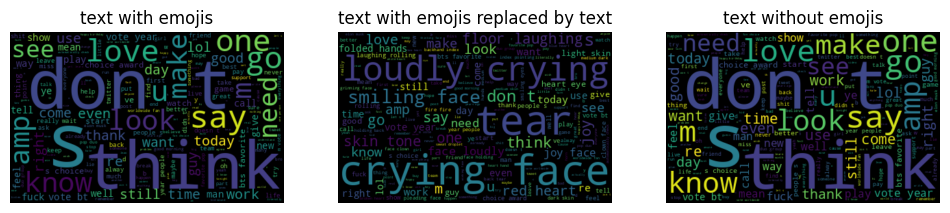

In [31]:
all_words_1 = ' '.join([text for text in df_emoji['processed_text']]) 
all_words_2 = ' '.join([text for text in df_emoji_text['processed_text']]) 
all_words_3 = ' '.join([text for text in df_no_emoji['processed_text']])

# create the WordCloud objects
wordcloud_1 = WordCloud(width=400, height=250, random_state=21, max_font_size=110).generate(all_words_1)
wordcloud_2 = WordCloud(width=400, height=250, random_state=21, max_font_size=110).generate(all_words_2)
wordcloud_3 = WordCloud(width=400, height=250, random_state=21, max_font_size=110).generate(all_words_3)

# create the subplots and display the WordClouds
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
axes[0].imshow(wordcloud_1, interpolation='bilinear')
axes[0].set_title('text with emojis')
axes[0].axis('off')
axes[1].imshow(wordcloud_2, interpolation='bilinear')
axes[1].set_title('text with emojis replaced by text')
axes[1].axis('off')
axes[2].imshow(wordcloud_3, interpolation='bilinear')
axes[2].set_title('text without emojis')
axes[2].axis('off')
plt.savefig("./drive/MyDrive/Comp 642 data/wordclouds.png", dpi=1000)
plt.show()

# Presentation: Bag-of-Words

In [ ]:
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df_emoji['processed_text'])
df_emoji_bow = csr_matrix(bag_of_words)

In [ ]:
bag_of_words = vectorizer.fit_transform(df_emoji_text['processed_text'])
df_emoji_bow = csr_matrix(bag_of_words)

In [ ]:
bag_of_words = vectorizer.fit_transform(df_no_emoji['processed_text'])
df_no_emoji_bow = csr_matrix(bag_of_words)

# Sentiment Analysis Algorithms
In this step, we shall fit the data in various calssifier and calculate various metrics of accuracy The algroithms we shall use are:

1. Naive Bayes
2. Logistic Regression
3. Random Forest
4. Linear SVC
5. XGBoost

The metrics of accuracy we shall use are:
1. Confusion Matrix
2. Accuracy Scores
3. Classification Report
We shall go with TF-IDF Vectorization for this case

# Bag-of-Words

# text with emojis

In [34]:
X = df_emoji["processed_text"]
y = df_emoji['sentiment']

In [ ]:
X_train_emoji, X_test_emoji, y_train_emoji, y_test_emoji = train_test_split(X, y, test_size=0.15, random_state=1, stratify=y)

In [10]:
#Building a pipeline
#Naive Bayes
classifier_nb = Pipeline([('bag_of_words',CountVectorizer()),
('clf',MultinomialNB())])

#Logistic regression
classifier_lr = Pipeline([('bag_of_words',CountVectorizer()),
('clf',LogisticRegression(solver='saga'))])

#Random Forest
classifier_rf = Pipeline([('bag_of_words',CountVectorizer()),
('clf',RandomForestClassifier(bootstrap= False, criterion= 'entropy', n_estimators= 100))])

#Linear SVC
classifier_svc = Pipeline([('bag_of_words',CountVectorizer()),
('clf',LinearSVC())])

In [11]:
def analyze(clf, X_test, X_train, y_train, y_test):
  #Predicting
  y_pred = clf.predict(X_test)
  yt_pred = clf.predict(X_train)
  #Analyzing
  cm = confusion_matrix(y_test,y_pred)
  print(f'Confusion Matrix :\n {cm}\n')
  print(f'Test Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
  print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
  print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

In [12]:
clfs = [classifier_nb, classifier_lr, classifier_rf, classifier_svc]

In [ ]:
for clf in clfs:
  clf.fit(X_train_emoji, y_train_emoji)
  analyze(clf, X_test_emoji, X_train_emoji, y_train_emoji, y_test_emoji)
  print("================================================================")

Confusion Matrix :
 [[21121  2236  3902]
 [ 3080 29311  9552]
 [ 2912  1970 40777]]

Test Set Accuracy Score :
 0.7940815420377674

Train Set Accuracy Score :
 0.8318952669794768

Classification Report :
               precision    recall  f1-score   support

    negative       0.78      0.77      0.78     27259
     neutral       0.87      0.70      0.78     41943
    positive       0.75      0.89      0.82     45659

    accuracy                           0.79    114861
   macro avg       0.80      0.79      0.79    114861
weighted avg       0.80      0.79      0.79    114861



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix :
 [[23267  2046  1946]
 [ 1286 39083  1574]
 [ 1588  1326 42745]]

Test Set Accuracy Score :
 0.9149754921165583

Train Set Accuracy Score :
 0.9288648801457732

Classification Report :
               precision    recall  f1-score   support

    negative       0.89      0.85      0.87     27259
     neutral       0.92      0.93      0.93     41943
    positive       0.92      0.94      0.93     45659

    accuracy                           0.91    114861
   macro avg       0.91      0.91      0.91    114861
weighted avg       0.91      0.91      0.91    114861

Confusion Matrix :
 [[22800  2155  2304]
 [ 1048 39609  1286]
 [ 1305  1532 42822]]

Test Set Accuracy Score :
 0.9161595319560164

Train Set Accuracy Score :
 0.9967658870995001

Classification Report :
               precision    recall  f1-score   support

    negative       0.91      0.84      0.87     27259
     neutral       0.91      0.94      0.93     41943
    positive       0.92      0.94      0.93   

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion Matrix :
 [[23243  2085  1931]
 [ 1396 38904  1643]
 [ 1591  1370 42698]]

Test Set Accuracy Score :
 0.912798948294025

Train Set Accuracy Score :
 0.9454118615891862

Classification Report :
               precision    recall  f1-score   support

    negative       0.89      0.85      0.87     27259
     neutral       0.92      0.93      0.92     41943
    positive       0.92      0.94      0.93     45659

    accuracy                           0.91    114861
   macro avg       0.91      0.91      0.91    114861
weighted avg       0.91      0.91      0.91    114861



In [ ]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_emoji_int = [label_map[label] for label in y_train_emoji]
y_test_emoji_int = [label_map[label] for label in y_test_emoji]

# Now you can use the integer-encoded labels in the XGBoost pipeline
classifier_xgb = Pipeline([('bag_of_words', CountVectorizer()),    
                           ('clf', xgb.XGBClassifier())])

classifier_xgb.fit(X_train_emoji, y_train_emoji_int)
analyze(classifier_xgb, X_test_emoji, X_train_emoji, y_train_emoji_int, y_test_emoji_int)

Confusion Matrix :
 [[15039  9306  2914]
 [  653 39988  1302]
 [ 1265  7833 36561]]

Test Set Accuracy Score :
 0.7973811824727279

Train Set Accuracy Score :
 0.798787476531556

Classification Report :
               precision    recall  f1-score   support

           0       0.89      0.55      0.68     27259
           1       0.70      0.95      0.81     41943
           2       0.90      0.80      0.85     45659

    accuracy                           0.80    114861
   macro avg       0.83      0.77      0.78    114861
weighted avg       0.82      0.80      0.79    114861



In [8]:
# Preprocess the text
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_emoji['text'].values)
X = tokenizer.texts_to_sequences(df_emoji['text'].values)
X = pad_sequences(X)

# One-hot encode the labels
Y = pd.get_dummies(df_emoji['sentiment']).values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# Define the LSTM model
embed_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train the model
batch_size = 64
epochs = 7
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test accuracy:', accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 37, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7
10113/10113 - 1398s - loss: 0.4824 - accuracy: 0.8317 - 1398s/epoch - 138ms/step
Epoch 2/7
10113/1011

## text with emojis replaced by text

In [11]:
X = df_emoji_text["processed_text"]
y = df_emoji_text['sentiment']

In [19]:
X_train_emoji_text, X_test_emoji_text, y_train_emoji_text, y_test_emoji_text = train_test_split(X, y, test_size=0.15, random_state=1, stratify=y)

In [15]:
for clf in clfs:
  clf.fit(X_train_emoji_text, y_train_emoji_text)
  analyze(clf, X_test_emoji_text, X_train_emoji_text, y_train_emoji_text, y_test_emoji_text)
  print("================================================================")

Confusion Matrix :
 [[20844  2653  3717]
 [ 3699 29141  8517]
 [ 3426  2541 39674]]

Test Set Accuracy Score :
 0.7850225895702728

Train Set Accuracy Score :
 0.8243559574228099

Classification Report :
               precision    recall  f1-score   support

    negative       0.75      0.77      0.76     27214
     neutral       0.85      0.70      0.77     41357
    positive       0.76      0.87      0.81     45641

    accuracy                           0.79    114212
   macro avg       0.79      0.78      0.78    114212
weighted avg       0.79      0.79      0.78    114212



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix :
 [[18234  5808  3172]
 [ 1377 38192  1788]
 [ 1814  4984 38843]]

Test Set Accuracy Score :
 0.8341417714425805

Train Set Accuracy Score :
 0.8368945659849104

Classification Report :
               precision    recall  f1-score   support

    negative       0.85      0.67      0.75     27214
     neutral       0.78      0.92      0.85     41357
    positive       0.89      0.85      0.87     45641

    accuracy                           0.83    114212
   macro avg       0.84      0.81      0.82    114212
weighted avg       0.84      0.83      0.83    114212

Confusion Matrix :
 [[22439  2333  2442]
 [  957 39066  1334]
 [ 1302  1754 42585]]

Test Set Accuracy Score :
 0.9113753370924246

Train Set Accuracy Score :
 0.9980083467114544

Classification Report :
               precision    recall  f1-score   support

    negative       0.91      0.82      0.86     27214
     neutral       0.91      0.94      0.92     41357
    positive       0.92      0.93      0.93   

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion Matrix :
 [[23154  2114  1946]
 [ 1390 38312  1655]
 [ 1673  1494 42474]]

Test Set Accuracy Score :
 0.9100619899835394

Train Set Accuracy Score :
 0.9441224596377323

Classification Report :
               precision    recall  f1-score   support

    negative       0.88      0.85      0.87     27214
     neutral       0.91      0.93      0.92     41357
    positive       0.92      0.93      0.93     45641

    accuracy                           0.91    114212
   macro avg       0.91      0.90      0.90    114212
weighted avg       0.91      0.91      0.91    114212



In [22]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_emoji_int = [label_map[label] for label in y_train_emoji_text]
y_test_emoji_int = [label_map[label] for label in y_test_emoji_text]

# Now you can use the integer-encoded labels in the XGBoost pipeline
classifier_xgb = Pipeline([('bag_of_words', CountVectorizer()),    
                           ('clf', xgb.XGBClassifier())])

classifier_xgb.fit(X_train_emoji_text, y_train_emoji_int)
analyze(classifier_xgb, X_test_emoji_text, X_train_emoji_text, y_train_emoji_int, y_test_emoji_int)

Confusion Matrix :
 [[14953  9270  2991]
 [  592 39459  1306]
 [ 1257  7810 36574]]

Test Set Accuracy Score :
 0.7966413336602108

Train Set Accuracy Score :
 0.7987116830783636

Classification Report :
               precision    recall  f1-score   support

           0       0.89      0.55      0.68     27214
           1       0.70      0.95      0.81     41357
           2       0.89      0.80      0.85     45641

    accuracy                           0.80    114212
   macro avg       0.83      0.77      0.78    114212
weighted avg       0.82      0.80      0.79    114212



In [ ]:
# Preprocess the text
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_emoji_text["processed_text"].values)
X = tokenizer.texts_to_sequences(df_emoji_text["processed_text"].values)
X = pad_sequences(X)

# One-hot encode the labels
Y = pd.get_dummies(df_emoji_text['sentiment']).values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# Define the LSTM model
embed_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train the model
batch_size = 64
epochs = 7
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test accuracy:', accuracy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 413, 128)          256000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 413, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7
10113/10113 - 12220s - loss: 0.4777 - accuracy: 0.8378 - 12220s/epoch - 1s/step
Epoch 2/7


## text without emojis

In [9]:
X = df_no_emoji["processed_text"]
y = df_no_emoji['sentiment']

In [24]:
X_train_no_emoji, X_test_no_emoji, y_train_no_emoji, y_test_no_emoji = train_test_split(X, y, test_size=0.15, random_state=1, stratify=y)

In [ ]:
for clf in clfs:
  clf.fit(X_train_no_emoji, y_train_no_emoji)
  analyze(clf, X_test_no_emoji, X_train_no_emoji, y_train_no_emoji, y_test_no_emoji)
  print("================================================================")

Confusion Matrix :
 [[21018  2246  3982]
 [ 2934 28950  8601]
 [ 3026  1908 40713]]

Test Set Accuracy Score :
 0.7998112508599552

Train Set Accuracy Score :
 0.8366974333431911

Classification Report :
               precision    recall  f1-score   support

    negative       0.78      0.77      0.78     27246
     neutral       0.87      0.72      0.79     40485
    positive       0.76      0.89      0.82     45647

    accuracy                           0.80    113378
   macro avg       0.81      0.79      0.79    113378
weighted avg       0.81      0.80      0.80    113378



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix :
 [[23132  2089  2025]
 [ 1199 37719  1567]
 [ 1569  1308 42770]]

Test Set Accuracy Score :
 0.9139427402141509

Train Set Accuracy Score :
 0.9280635671704516

Classification Report :
               precision    recall  f1-score   support

    negative       0.89      0.85      0.87     27246
     neutral       0.92      0.93      0.92     40485
    positive       0.92      0.94      0.93     45647

    accuracy                           0.91    113378
   macro avg       0.91      0.91      0.91    113378
weighted avg       0.91      0.91      0.91    113378

Confusion Matrix :
 [[22856  2052  2338]
 [  974 38213  1298]
 [ 1332  1423 42892]]

Test Set Accuracy Score :
 0.9169415583270123

Train Set Accuracy Score :
 0.9968605538001775

Classification Report :
               precision    recall  f1-score   support

    negative       0.91      0.84      0.87     27246
     neutral       0.92      0.94      0.93     40485
    positive       0.92      0.94      0.93   

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion Matrix :
 [[23154  2113  1979]
 [ 1308 37550  1627]
 [ 1584  1407 42656]]

Test Set Accuracy Score :
 0.9116407063098662

Train Set Accuracy Score :
 0.944719597802232

Classification Report :
               precision    recall  f1-score   support

    negative       0.89      0.85      0.87     27246
     neutral       0.91      0.93      0.92     40485
    positive       0.92      0.93      0.93     45647

    accuracy                           0.91    113378
   macro avg       0.91      0.90      0.91    113378
weighted avg       0.91      0.91      0.91    113378



In [26]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_emoji_int = [label_map[label] for label in y_train_no_emoji]
y_test_emoji_int = [label_map[label] for label in y_test_no_emoji]

# Now you can use the integer-encoded labels in the XGBoost pipeline
classifier_xgb = Pipeline([('bag_of_words', CountVectorizer()),    
                           ('clf', xgb.XGBClassifier())])

classifier_xgb.fit(X_train_no_emoji, y_train_emoji_int)
analyze(classifier_xgb, X_test_no_emoji, X_train_no_emoji, y_train_emoji_int, y_test_emoji_int)

Confusion Matrix :
 [[15264  8965  2984]
 [  706 37827  1321]
 [ 1303  7678 36654]]

Test Set Accuracy Score :
 0.7963035261131125

Train Set Accuracy Score :
 0.8002401971683666

Classification Report :
               precision    recall  f1-score   support

           0       0.88      0.56      0.69     27213
           1       0.69      0.95      0.80     39854
           2       0.89      0.80      0.85     45635

    accuracy                           0.80    112702
   macro avg       0.82      0.77      0.78    112702
weighted avg       0.82      0.80      0.79    112702



In [10]:
# Preprocess the text
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_no_emoji["processed_text"].values)
X = tokenizer.texts_to_sequences(df_no_emoji["processed_text"].values)
X = pad_sequences(X)

# One-hot encode the labels
Y = pd.get_dummies(df_no_emoji['sentiment']).values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# Define the LSTM model
embed_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train the model
batch_size = 64
epochs = 7
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test accuracy:', accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 35, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7
9979/9979 - 1120s - loss: 0.4666 - accuracy: 0.8431 - 1120s/epoch - 112ms/step
Epoch 2/7
9979/9979 - 

# Performance

In [14]:
df = pd.DataFrame({
  'data': ['Text with emojis', 'Text with emoji descriptions', 'Text without emojis'],  
  'Naive Bayes': [79.41, 78.5, 79.98],
  'Logistic Regression':[91.5, 83.41, 91.39],
  'Random Forest':[91.62, 91.13, 91.69],
  'Linear SVC':[91.3, 91.01, 91.16],
  'XGBoost':[79.73, 79.66, 79.63],
  'LSTM':[87.03, np.nan, 87.65],
})
df = df.set_index('data')
display(df)

,Naive Bayes,Logistic Regression,Random Forest,Linear SVC,XGBoost,LSTM
data,,,,,,
Text with emojis,79.41,91.50,91.62,91.30,79.73,87.03
Text with emoji descriptions,78.50,83.41,91.13,91.01,79.66,NaN
Text without emojis,79.98,91.39,91.69,91.16,79.63,87.65
